<a href="https://colab.research.google.com/github/aryan7786engg-sudo/alzheimer-detection/blob/main/ALZHEIMERprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [5]:
!rm -rf /content/data
!mkdir -p /content/data

!unzip -qo "/content/drive/MyDrive/archive.zip" -d "/content/data"

!ls /content/data


Data


In [6]:
!pip install split-folders
import splitfolders

splitfolders.ratio(
    '/content/data/Data',           # your source folder
    output='/content/data',         # where to save
    seed=42,                        # for reproducibility
    ratio=(0.7, 0.2, 0.1)           # 70% train, 20% val, 10% test
)

!ls /content/data


Copying files: 86437 files [00:17, 5057.13 files/s]


Data  test  train  val


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/data/train'
val_dir = '/content/data/val'

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 60504 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [12]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8,
    batch_size=32,
    callbacks=[checkpoint]
)


Epoch 1/8
 423/1891 ━━━━━━━━━━━━━━━━━━━━ 9:07 373ms/step - accuracy: 0.8300 - loss: 0.4228

KeyboardInterrupt: 

In [13]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/best_model.keras")
print("✅ Best model loaded")


✅ Best model loaded


In [14]:
val_loss, val_acc = model.evaluate(val_gen)
print("Validation Accuracy:", val_acc)
print("Validation Loss:", val_loss)


541/541 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.8417 - loss: 0.3891
Validation Accuracy: 0.8429943323135376
Validation Loss: 0.3855613172054291


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_dir = "/content/data/test"

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


Found 8647 images belonging to 4 classes.
271/271 ━━━━━━━━━━━━━━━━━━━━ 23s 86ms/step - accuracy: 0.8050 - loss: 0.4798
Test Accuracy: 0.8482710719108582


271/271 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step


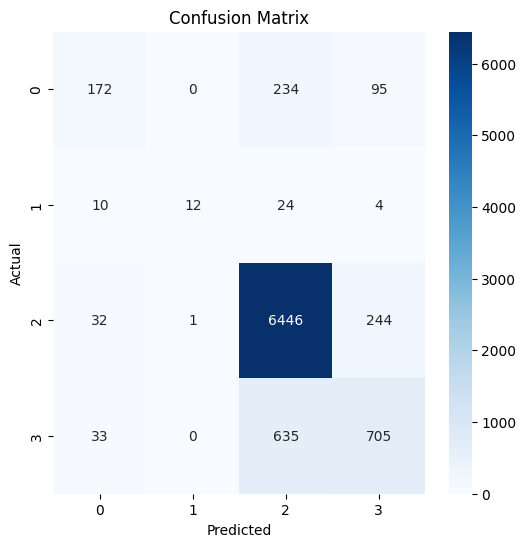

              precision    recall  f1-score   support

           0       0.70      0.34      0.46       501
           1       0.92      0.24      0.38        50
           2       0.88      0.96      0.92      6723
           3       0.67      0.51      0.58      1373

    accuracy                           0.85      8647
   macro avg       0.79      0.51      0.59      8647
weighted avg       0.84      0.85      0.83      8647



In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

true_classes = test_gen.classes
pred_probs = model.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(true_classes, pred_classes))


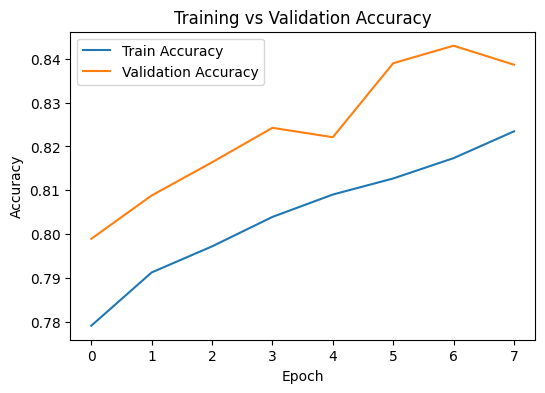

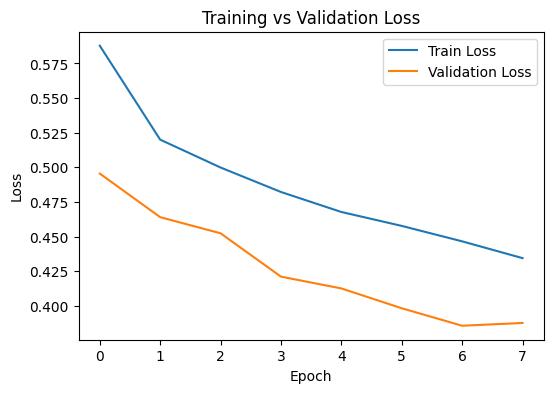

In [17]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss graph
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
import os

classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very Mild Dementia"]

counts = [len(os.listdir(f"/content/data/train/{c}")) for c in classes]

plt.figure(figsize=(6,4))
plt.bar(classes, counts)
plt.title("Number of Images per Class (Train Set)")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train/Very Mild Dementia'

In [19]:
!ls /content/data/train


'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


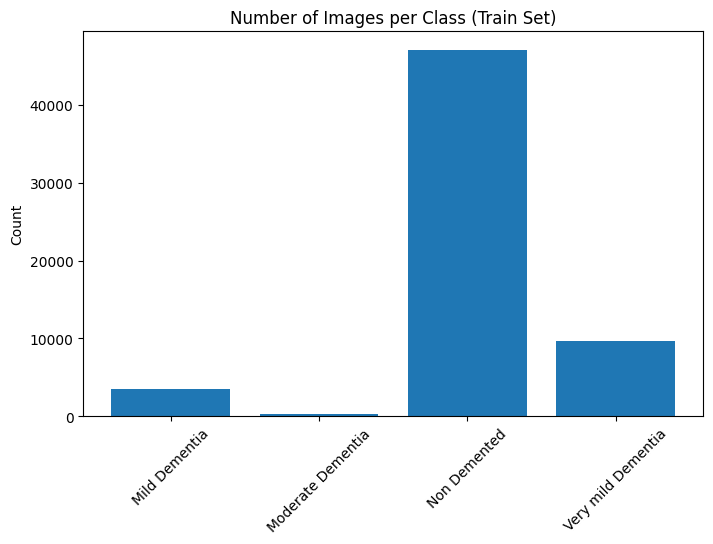

In [20]:
import os
import matplotlib.pyplot as plt

classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

counts = [len(os.listdir(f"/content/data/train/{c}")) for c in classes]

plt.figure(figsize=(8,5))
plt.bar(classes, counts)
plt.title("Number of Images per Class (Train Set)")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


In [21]:
!cp "/content/drive/MyDrive/best_model.keras" "best_model.keras"


In [22]:
%%writefile app.py
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

st.set_page_config(page_title="Alzheimer Detection", layout="centered")

st.title("🧠 Alzheimer Disease Detection Using Deep Learning")
st.write("Upload an MRI image to detect the stage of Alzheimer's Disease.")

model = load_model("best_model.keras")
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

uploaded = st.file_uploader("Upload MRI Image", type=["jpg","jpeg","png"])

if uploaded:
    st.image(uploaded, caption="Uploaded MRI Image", width=250)

    img = image.load_img(uploaded, target_size=(224,224))
    img_arr = image.img_to_array(img)/255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    predictions = model.predict(img_arr)
    pred_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    st.success(f"### ✅ Prediction: **{classes[pred_index]}**")
    st.info(f"Confidence: **{confidence:.2f}%**")


Writing app.py


In [23]:
!pip install streamlit
!pip install pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.9 MB/s eta 0:00:00


In [24]:
from pyngrok import ngrok

# Start Streamlit
public_url = ngrok.connect(port=8501)
public_url


ERROR:pyngrok.process.ngrok:t=2025-11-09T06:15:32+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-11-09T06:15:32+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-11-09T06:15:32+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [25]:
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 22 packages in 3s
⠙
⠙3 packages are looking for funding
⠙  run `npm fund` for details
⠙

In [28]:
!streamlit run app.py --server.port 8501 & lt --port 8501


your url is: https://great-maps-prove.loca.lt



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.11.181.90:8501

2025-11-09 06:23:46.122792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762669426.145224   40827 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762669426.152007   40827 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762669426.169145   40827 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762669426.169172   40827 com

In [27]:
!curl -s https://loca.lt/mytunnelpassword


34.11.181.90

In [29]:
!ls -lh best_model.keras


-rw------- 1 root root 12M Nov  9 06:14 best_model.keras


In [30]:
!streamlit run app.py --server.port 8501 & lt --port 8501


your url is: https://proud-weeks-say.loca.lt



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.11.181.90:8501

  Stopping...
^C


In [31]:
!curl -s https://loca.lt/mytunnelpassword


34.11.181.90

In [32]:
from google.colab import files
files.download("app.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
from google.colab import files
files.download("/content/drive/MyDrive/best_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
%%writefile requirements.txt
streamlit
tensorflow
numpy
pillow


Writing requirements.txt


In [35]:
from google.colab import files
files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>